# Analysis of COVID Data and Politicial Outcomes for the United States

### By: Rushabh Shah, Michael Bouyat

## Table of Contents

1. [Introduction](#Introduction)
2. [Data Collection](#DataCollection)
3. [Data Preparation](#DataPreparation)
    1. [Combine COVID Cases and Deaths Per State, Population Per State, and State Abbreviations](#3.A)
    2. [Determine Presidential Winners for States from County Election Data](#3.B)
    3. [Combining State COVID Data and Presidential Winners Per State](#3.C)
4. [Exploratory Data Analysis](#EDA)
    1. [Trends of COVID Cases and Deaths For All States](#4.A)
    2. [Trends of COVID Cases Per U.S. Region](#4.B)
    3. [Trends of COVID Deaths Per U.S. Region](#4.C)
    4. [Trends of States' COVID Cases Based on Their 2020 Presidential Election Outcome](#4.D)
    5. [Trends of States' COVID Deaths Based on Their 2020 Presidential Election Outcome](#4.E)
5. [Statistical Analysis and Machine Learning](#5)
    1. [Linear Regression for Predicting the Total Number of Cases](#5.A)
    2. [Linear Regression for Predicting the Total Number of Deaths](#5.B)
    3. [Classifying States' Political Outcomes with Their COVID Data Using Random Forest Classification](#5.C)
6. [Policy Insights and Conclusions](#6)
    
    
    

## 1. Introduction <a name="Introduction"></a>

The [COVID-19 pandemic](https://www.cdc.gov/coronavirus/2019-ncov/index.html) has taken the entire world by storm. It seems that every day we are hearing about [record numbers of infections](https://www.cnn.com/interactive/2020/health/coronavirus-us-maps-and-cases/) nationally or for a particular state. Due in part to the magnitude of the problem, the [pandemic has become politicized](https://www.theguardian.com/us-news/2020/dec/17/trump-penned-political-suicide-note-at-every-covid-press-conference-former-australian-pm-says), leading to a whirlwind of accusations from all angles in the news about who is to blame. This politicization of the crisis has left the average American in the dark about the true nature of the crisis and what measures have/have not been effective. For this reason, we have decided to examine a few nationwide factors to determine their influence on efforts to contain the pandemic. We are specifically looking at the total number of cases and deaths for each state in [four regions of the country](https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States#Census_Bureau-designated_regions_and_divisions): Northeast, Midwest, South and West. In addition, we will examine how cases and deaths, proportional to a state's population, are different in states that voted Democrat and Republican in the [2020 Presidential Election](https://en.wikipedia.org/wiki/2020_United_States_presidential_election). Finally, we use machine learning to develop models of the nation's rise in cases and deaths. We also develop a model to classify a state's political outcome given its COVID data.

### Required Tools:
1. [numpy](https://numpy.org/doc/stable/)
2. [pandas](https://pandas.pydata.org/docs/)
3. [datetime](https://docs.python.org/3/library/datetime.html)
4. [matplotlib](https://matplotlib.org/contents.html)
5. [seaborn](https://seaborn.pydata.org/tutorial.html)
6. [plotly](https://plotly.com/python/)
7. [sklearn](https://scikit-learn.org/stable/user_guide.html)

### Imports and Initial Setup

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import plotly.express as px
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
sns.set()

## 2. Data Collection <a name="DataCollection"></a>

We are going to begin our investigation of the COVID pandemic by making use of a few different datasets provided by different sources. The [first](https://github.com/nytimes/covid-19-data) was made by the New York Times and contains each state's daily totals of cases and deaths starting from January 21, 2020. The [second dataset](https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-detail.html#par_textimage) comes from the U.S. Census Bureau and contains information about the population of each state based on their 2019 estimates. This will be very useful later in our analysis. The [third dataset](https://www.kaggle.com/unanimad/us-election-2020?select=president_county_candidate.csv) was provided by a user on Kaggle and it examines the presidential candidate that won each county of each state. Finally, the [fourth dataset](https://worldpopulationreview.com/states/state-abbreviations) is from the World Population Review and it contains abbreviations and two letter codes for each state. 

In [123]:
# Import datasets from CSV files
state_covid = pd.read_csv('us-states.csv')
population = pd.read_csv('population_data.csv')
election = pd.read_csv('president_county_candidate.csv')
abbreviations = pd.read_csv('state_abbreviations.csv')

display(state_covid.head(3))
display(population.head(3))
display(election.head(3))
display(abbreviations.head(3))

date       state  fips  cases  deaths
0  2020-01-21  Washington    53      1       0
1  2020-01-22  Washington    53      1       0
2  2020-01-23  Washington    53      1       0

SUMLEV REGION DIVISION  STATE           NAME  POPESTIMATE2019  \
0      10      0        0      0  United States        328239523   
1      40      3        6      1        Alabama          4903185   
2      40      4        9      2         Alaska           731545   

   POPEST18PLUS2019  PCNT_POPEST18PLUS  
0         255200373               77.7  
1           3814879               77.8  
2            551562               75.4

state       county     candidate party  total_votes    won
0  Delaware  Kent County     Joe Biden   DEM        44552   True
1  Delaware  Kent County  Donald Trump   REP        41009  False
2  Delaware  Kent County  Jo Jorgensen   LIB         1044  False

State  Abbrev Code
0  Alabama    Ala.   AL
1   Alaska  Alaska   AK
2  Arizona   Ariz.   AZ

## 3. Data Preparation <a name="DataPreparation"></a>

Now that the data has all been gathered, we need to combine the data in useful ways to see if anything of note becomes visible. So, we will continue by combining data from the previously created dataframes into one. An important point to note with the newly created [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) is that it includes a column showing the amount of cases for a particular state relative to their population. This is vital to include as states such as California, New York, or Texas are naturally going to have a large number of cases due to their large populations. The results from these states would skew the data we are trying to collect. In addition, each state is marked as belonging to one of four regions: Northeast, Midwest, South and West. 

### 3.A Combine COVID Cases and Deaths Per State, Population Per State, and State Abbreviations <a name="3.A"></a>

In [124]:
# Drop unnecessary and rename columns in the population dataset
population = population.iloc[1:]
population = population.drop(columns=['SUMLEV', 'DIVISION', 'POPEST18PLUS2019', 'PCNT_POPEST18PLUS'])
population = population.rename(columns={'STATE': 'STATE_NUM'})
population.head()

# Determine the number of days passed for each record from the first day recorded in the dataset (01/21/2020)
state_covid['date'] = pd.to_datetime(state_covid['date'])
state_covid['date'] = state_covid['date'].dt.date
state_covid['num_days'] = state_covid['date'].transform(lambda x: (x - dt.date(2020, 1, 21)).days)

# Merge columns from both tables for each state
state_covid = state_covid.merge(population, left_on='state', right_on='NAME')

# Drop unnecessary and rename columns in the merged dataset
state_covid = state_covid.drop(columns=['STATE_NUM', 'NAME'])
state_covid = state_covid.rename(columns={'fips': 'state_num', 'REGION': 'region', 'POPESTIMATE2019': 'population'})
state_covid.head()

# Adjust cases and deaths to reflect the population (i.e. percentage of population infected or dead)
cases_adjusted = []
deaths_adjusted = []
for index, row in state_covid.iterrows():
    cases_adjusted.append(row[3]/row[7])
    deaths_adjusted.append(row[4]/row[7])
    
state_covid['cases_adj'] = pd.Series(cases_adjusted)
state_covid['deaths_adj'] = pd.Series(deaths_adjusted)

# Define function to convert region number to name (determined by U.S. Census Bureau)
def region_num_to_name(x):
    if x == '1':
        return 'Northeast'
    elif x == '2':
        return 'Midwest'
    elif x == '3':
        return 'South'
    else:
        return 'West'

# Transform region numbers to names using the function above
state_covid['region_name'] = state_covid['region'].transform(region_num_to_name)
# state_covid = state_covid.drop(columns='region')

# Merge abbreviations with state covid data
state_covid = state_covid.merge(abbreviations, left_on='state', right_on='State')
state_covid = state_covid.drop(columns=['State', 'Abbrev'])
state_covid = state_covid.rename(columns={'Code': 'code'})

state_covid.head(3)

date       state  state_num  cases  deaths  num_days region  \
0  2020-01-21  Washington         53      1       0         0      4   
1  2020-01-22  Washington         53      1       0         1      4   
2  2020-01-23  Washington         53      1       0         2      4   

   population     cases_adj  deaths_adj region_name code  
0     7614893  1.313216e-07         0.0        West   WA  
1     7614893  1.313216e-07         0.0        West   WA  
2     7614893  1.313216e-07         0.0        West   WA

### 3.B Determine Presidential Winners for States from County Election Data <a name="3.B"></a>

Now that we’ve consolidated the COVID data from the various data frames created earlier, we must prepare some data from the next part of our analysis. We found the results of the recent presidential election by county; now we will combine this data so we have the winner by state.

In [125]:
# Group the dataframe by state
state_election = election.groupby('state')

# Store the winners of each state in a dictionary
election_dict = dict()

# For each state, iterate through counties in order to tally votes and determine a winnner 
for index, df in state_election:
    biden = 0
    trump = 0
    for row_index, row in df.iterrows():
        if row[2] == 'Joe Biden':
            biden += row[4]
        elif row[2] == 'Donald Trump':
            trump += row[4]
    
    if biden > trump:
        election_dict[index] = 'Biden'
    else:
        election_dict[index] = 'Trump'

# Convert the dictioanry to the DataFrame
election = pd.DataFrame(list(election_dict.items()), columns=['state', 'winner'])
display(election.head(3))

state winner
0  Alabama  Trump
1   Alaska  Trump
2  Arizona  Biden

### 3.C Combining State COVID Data and Presidential Winners Per State <a name="3.C"></a>

Next, we combine the previously created data with the overall COVID data.

In [126]:
# Merge the election DataFrame into the state_covid DataFrame
state_covid = state_covid.merge(election, left_on='state', right_on='state')
state_covid.head(3)

date       state  state_num  cases  deaths  num_days region  \
0  2020-01-21  Washington         53      1       0         0      4   
1  2020-01-22  Washington         53      1       0         1      4   
2  2020-01-23  Washington         53      1       0         2      4   

   population     cases_adj  deaths_adj region_name code winner  
0     7614893  1.313216e-07         0.0        West   WA  Biden  
1     7614893  1.313216e-07         0.0        West   WA  Biden  
2     7614893  1.313216e-07         0.0        West   WA  Biden

## 4. Exploratory Data Analysis <a name="EDA"></a>

After getting all of our data in the right form, we can begin to see what the data looks like. First we just want to see what all of the data looks like plotted out on a graph. Then, we begin to investigate how the trends of cases and deaths vary for different regions of the country. Visualizing this data on an interactive map allows us to see over time how cases/deaths rose in different states over time. We also take look at how a state's political outcome affected its COVID statistics. 

### 4.A Trends of COVID Cases and Deaths For All States <a name="4.A"></a>

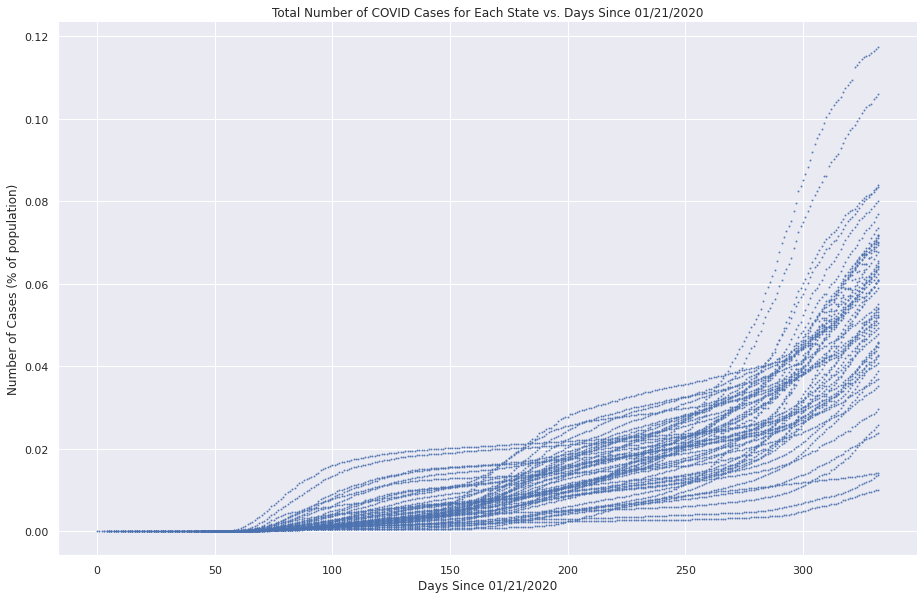

In [127]:
# Create plots showing the adjusted number of cases for each state over time
plot = sns.lmplot(x='num_days',y='cases_adj',data=state_covid,fit_reg=False, height=8.27, aspect=13/8.27, scatter_kws={"s": 1})
plot = plot.set(title='Total Number of COVID Cases for Each State vs. Days Since 01/21/2020')
plot = plot.set(xlabel='Days Since 01/21/2020', ylabel='Number of Cases (% of population)')

We begin by creating a scatter plot of COVID cases per day for each state. As you can see, the first spike in the number of cases occurs between 50 and 100 days from the 21st of January. The next spike occurs between 150 and 200 days from the 21st. Finally, a massive spike occurs from 250 to 300 days from the 21st. Keep in mind, these numbers are proportional to the population of each individual state. So, the massive spike cannot be explained simply by the virus reaching a large state such as California and New York.

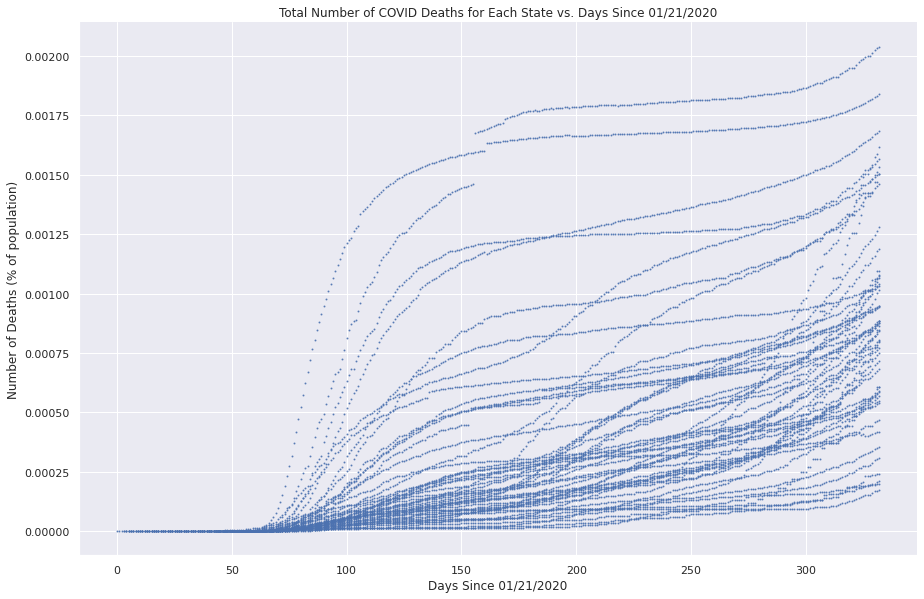

In [128]:
# Create plots showing the adjusted number of deaths for each state over time
plot = sns.lmplot(x='num_days',y='deaths_adj',data=state_covid,fit_reg=False, height=8.27, aspect=13/8.27, scatter_kws={"s": 1})
plot = plot.set(title='Total Number of COVID Deaths for Each State vs. Days Since 01/21/2020')
plot = plot.set(xlabel='Days Since 01/21/2020', ylabel='Number of Deaths (% of population)')

We continue by creating a plot of COVID deaths per day for each state. Once again, the numbers are adjusted to represent deaths relative to the overall population of each state. Interestingly, we see a deviation from the previous graph. Between 50 to 100 days, we see a massive spike in deaths in a noteworthy amount of states, a moderate spike in other states and only a small spike in others. This data is clearly suggesting that [some states were more effective in their pandemic response than others](https://www.verywellhealth.com/covid-19-response-city-state-response-5086171). We will investigate soon whether this can be directly correlated to the political climate of individual states.

### 4.B Trends of COVID Cases Per U.S. Region <a name="4.B"></a>

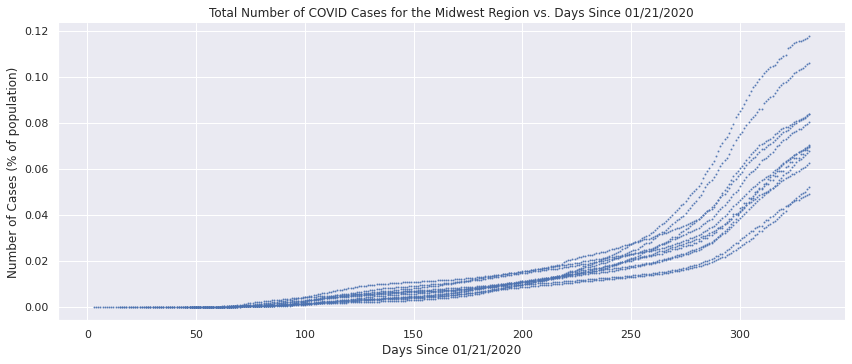

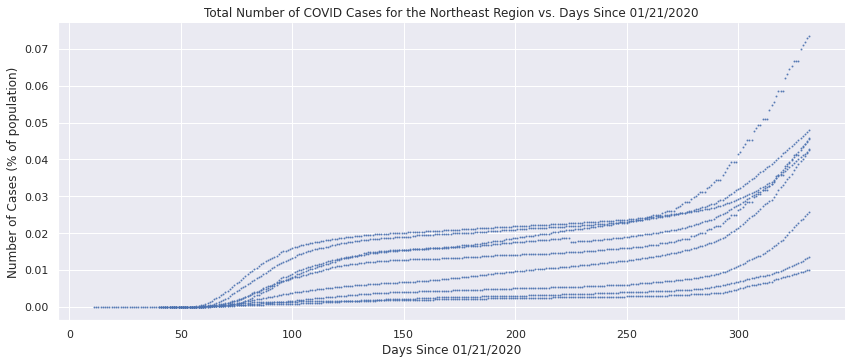

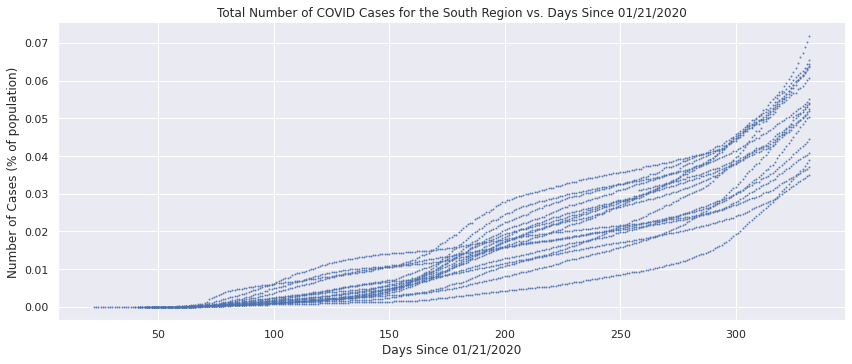

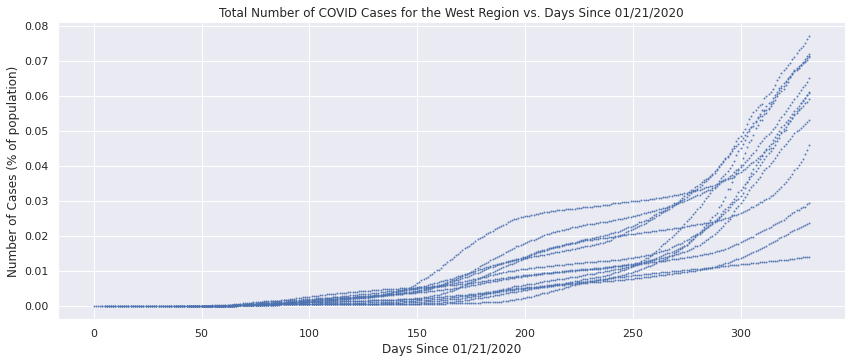

In [129]:
# Create separate plots for all states within each of the 4 regions of the U.S. and their number of cases
regions = state_covid.groupby('region_name')
for region_name, df in regions:
    
    plot = sns.lmplot(x='num_days',y='cases_adj',data=df,fit_reg=False, height=5, aspect=12/5, scatter_kws={"s": 1} )
    
    # Set appropriate title and axis labels
    plot.set(title='Total Number of COVID Cases for the ' + region_name + ' Region vs. Days Since 01/21/2020')
    plot.set(xlabel='Days Since 01/21/2020', ylabel='Number of Cases (% of population)')

Next, we will take a higher level look at the same data. We previously divided up the states into four regions: Northeast, Midwest, South and West. Now, we’ll examine each of the regions based on the number of COVID cases, then deaths per day. We begin with the Midwest and we see that they were able to avoid the earlier spikes at 50 to 100 days and 150 to 200 days as seen in the national graph. Spikes occur between 250 to 300 days, seemingly suggesting that the midwest did a relatively good job of containing the pandemic in the early stages. The Northeast had an early spike between 50 to 100 days then stayed relatively consistent in the number of cases until 250 to 300 days. This seems to suggest that the Northeast started off slower but was able to “flatten the curve.” The South and West had similar outcomes. They avoided early spikes, but they seemed to lose control between 150 to 200 days then struggled to contain the pandemic after. 

### Interactive Map of COVID Cases for Each State Over Time 

Here is an [interactive map](https://plotly.com/python/choropleth-maps/) that visualizes the above data in a different format. This specific map looks at the increase in the total number of cases over time for each state. Press play on the map to see the animation. Hovering your mouse over any of the states gives its two letter abbreviation and the data point being represented.

In [130]:
# Use plotly to create an interactive map that shows the adjusted cases for each state over time
fig = px.choropleth(state_covid, 
              locations = 'code',
              color="cases_adj", 
              animation_frame="num_days",
              color_continuous_scale="reds",
              locationmode='USA-states',
              scope="usa",
              range_color=(0, 0.10),
              title='COVID Cases (Adjusted for Percentage of Population) for Each State Vs. Time',
              height=600
             )

# Change the transition and frame speed
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 20
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 0
fig

### 4.C Trends of COVID Deaths Per U.S. Region <a name="4.C"></a>

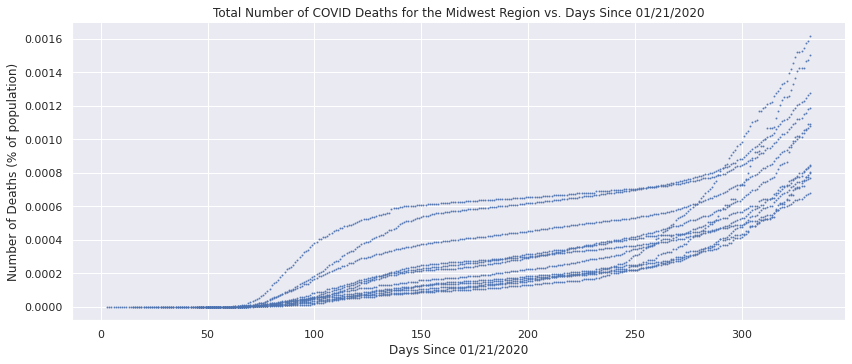

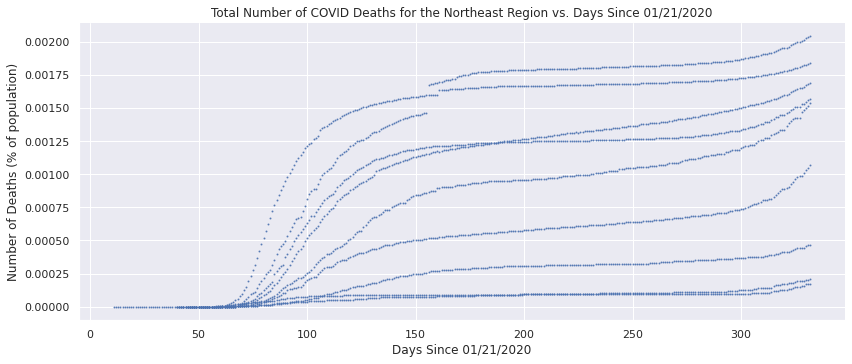

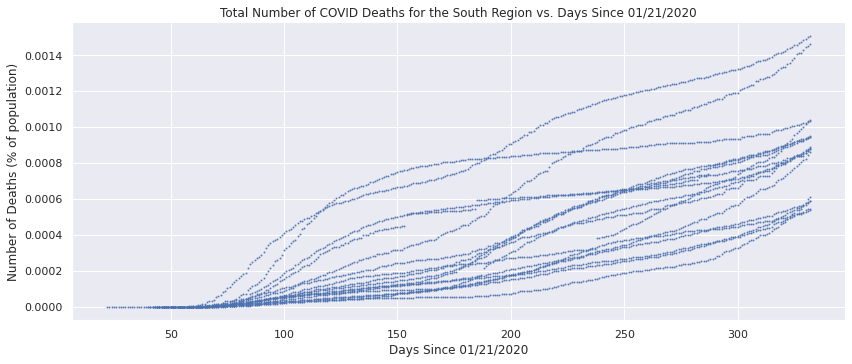

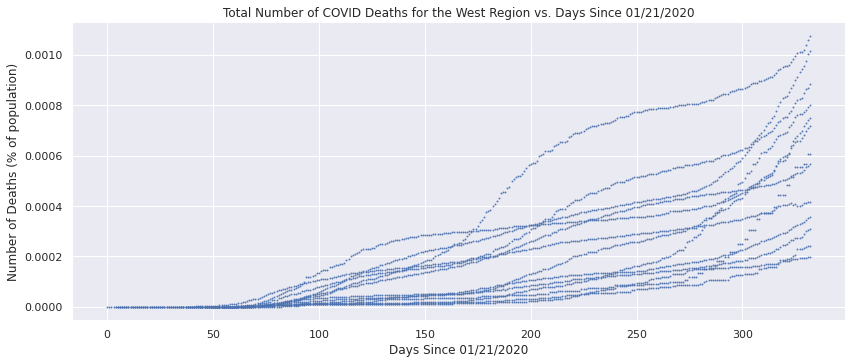

In [131]:
# Create separate plots for all states within each of the 4 regions of the U.S. and their number of deaths
regions = state_covid.groupby('region_name')

for region_name, df in regions:
    
    plot = sns.lmplot(x='num_days',y='deaths_adj',data=df,fit_reg=False, height=5, aspect=12/5, scatter_kws={"s": 1} )
    
    # Set appropriate title and axis labels
    plot.set(title='Total Number of COVID Deaths for the ' + region_name + ' Region vs. Days Since 01/21/2020')
    plot.set(xlabel='Days Since 01/21/2020', ylabel='Number of Deaths (% of population)')

Following the number of cases, we examine the number of deaths by region. The Midwest had an early spike in deaths that appears to have been contained until the 250 to 300 days. The Northeast was most affected by the pandemic with massive spikes in death as early as between the 50 to 100 day mark. A few states did an excellent job of preventing deaths, but overall this region was hit the hardest. The South had an early spike in deaths that was eventually contained only briefly. The West was able to control deaths early but began to struggle around the 150 to 200 day mark. 

### Interactive Map of COVID Deaths for Each State Over Time

In [132]:
# Use plotly to create an interactive map that shows the adjusted deaths for each state over time
fig = px.choropleth(state_covid, 
              locations = 'code',
              color="deaths_adj", 
              animation_frame="num_days",
              color_continuous_scale="blues",
              locationmode='USA-states',
              scope="usa",
              range_color=(0, 0.00175),
              title='COVID Deaths (Adjusted for Percentage of Population) for Each State Vs. Time',
              height=600
             )

# Change the transition and frame speed
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 20
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 0
fig

### 4.D Trends of States' COVID Cases Based on Their 2020 Presidential Election Outcome <a name="4.D"></a>

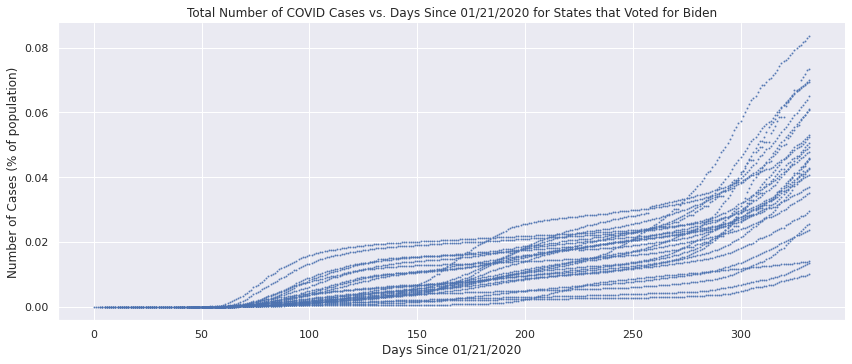

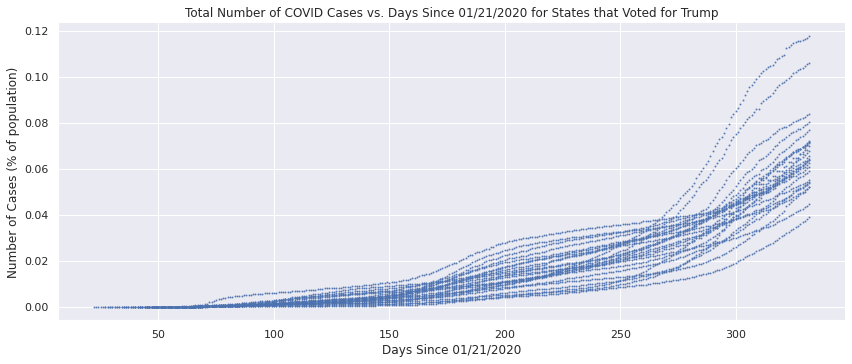

In [133]:
# Create separate plots for all states that voted for a certain political candidate and their number of cases
candidates = state_covid.groupby('winner')

for candidate_name, df in candidates:
    
    plot = sns.lmplot(x='num_days',y='cases_adj',data=df,fit_reg=False, height=5, aspect=12/5, scatter_kws={"s": 1} )
    
    # Set appropriate title and axis labels
    plot.set(title='Total Number of COVID Cases vs. Days Since 01/21/2020 for States that Voted for ' + candidate_name)
    plot.set(xlabel='Days Since 01/21/2020', ylabel='Number of Cases (% of population)')

Our final piece of analysis involves plotting the amount of COVID cases by states that Biden won and COVID cases for states that Trump won. Once again the numbers are adjusted to be proportional to the states populations. The graphs show that the states won by Trump overall had more cases than those won by Biden. It also appears that Biden states started seeing the virus spread earlier in the year than Trump states did. Note that the y-axis reaches a higher number on the Trump state graphs making the graphs seem more equal than they really are.

In [134]:
# Copy the state_covid DataFrame and make one candidate's values negative. Using positive and negative values
# with a midpoint of 0 enables using a diverging colorscale for the graph.
graph_df = state_covid.copy()
graph_df.loc[graph_df.winner == 'Biden', 'cases_adj'] = graph_df.loc[graph_df.winner == 'Biden', 'cases_adj'] * (-1)
graph_df.loc[graph_df.winner == 'Biden', 'deaths_adj'] = graph_df.loc[graph_df.winner == 'Biden', 'deaths_adj'] * (-1)

# Use plotly to create an interactive map that shows the adjusted cases for each state over time, depending on what
# the political outcome of that state was. States that voted for Joe Biden are represented in blue and states that
# voted for Donald Trump are represented in red.
fig = px.choropleth(graph_df, 
              locations = 'code',
              color="cases_adj", 
              animation_frame="num_days",
              color_continuous_scale=px.colors.diverging.balance,
              color_continuous_midpoint=0.0,
              locationmode='USA-states',
              scope="usa",
              title='COVID Cases (Adj. for % of Population) for Each State Depending on Political Outcome Vs. Time',
              height=600
             )

# Change the transition and frame speed
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 20
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 0
fig

### 4.E Trends of States' COVID Deaths Based on Their 2020 Presidential Election Outcome <a name="4.E"></a>


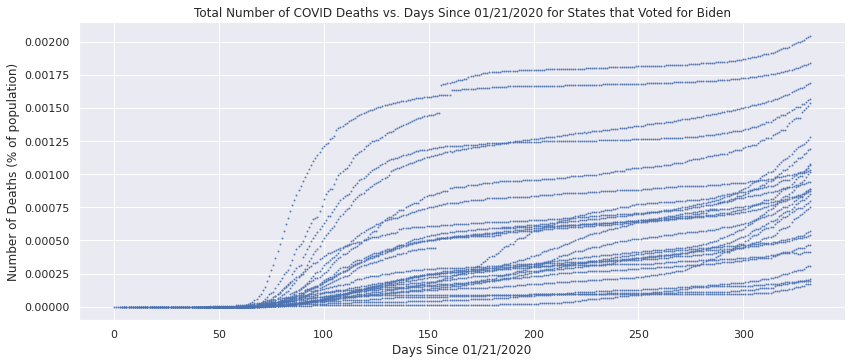

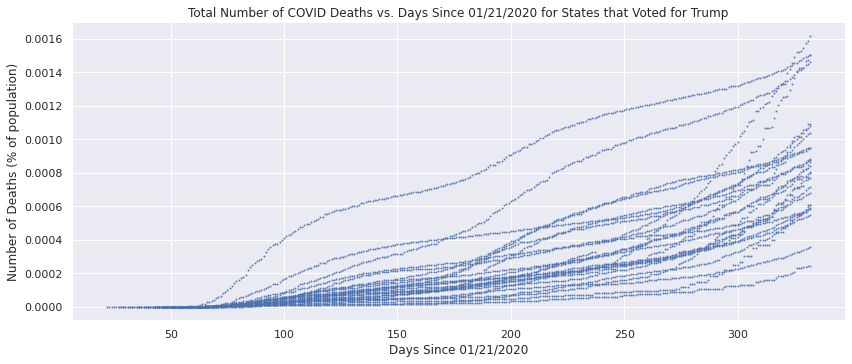

In [135]:
# Create separate plots for all states that voted for a certain political candidate and their number of deaths
candidates = state_covid.groupby('winner')

for candidate_name, df in candidates:
    
    plot = sns.lmplot(x='num_days',y='deaths_adj',data=df,fit_reg=False, height=5, aspect=12/5, scatter_kws={"s": 1} )
    
    # Set appropriate title and axis labels
    plot.set(title='Total Number of COVID Deaths vs. Days Since 01/21/2020 for States that Voted for ' + candidate_name)
    plot.set(xlabel='Days Since 01/21/2020', ylabel='Number of Deaths (% of population)')

Surprisingly, the amount of deaths in the Biden voting states exceeded that of the Trump states. There is a larger spike between 50 to 100 in the Biden voting states. The spike comes at the same time as the Trump states. It is hard to even speculate why this is. Perhaps, there is worse medical care in Biden states which typically contain big cities. Or perhaps, there are more low socioeconomic status people in close proximity to one another in these cities. Metropolitan areas have been [hit the hardest](https://www.brookings.edu/blog/the-avenue/2020/04/01/why-it-will-be-difficult-to-restart-the-economy-after-covid-19/) by COVID. The Biden states seemed to be successful in dramatically flattening the curve after a dramatic spike. This curve flattening coincides with the nationwide institution of lockdowns, stay at home orders, and other executive action to try and control the spread of the virus. 

In [136]:
# Use plotly to create an interactive map that shows the adjusted deaths for each state over time, depending on what
# the political outcome of that state was. States that voted for Joe Biden are represented in blue and states that
# voted for Donald Trump are represented in red.
fig = px.choropleth(graph_df, 
              locations = 'code',
              color="deaths_adj", 
              animation_frame="num_days",
              color_continuous_scale=px.colors.diverging.balance,
              color_continuous_midpoint=0.0,
              locationmode='USA-states',
              scope="usa",
              title='COVID Deaths (Adj. for % of Population) for Each State Depending on Political Outcome Vs. Time',
              height=600
             )

# Change the transition and frame speed
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 20
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 0
fig

## 5. Statistical Analysis and Machine Learning <a name="5"></a>

Now that we've explored what the data looks like and noticed that there are visual trends that appear in the graphs, we are going to try to create a model to represent it. In this section, we will create models for the total number of cases in the United States as time increases, the total number of deaths as time increaes, and classifying the political outcomes of states using their COVID data.

### 5.A Linear Regression for Predicting the Total Number of Cases <a name="5.A"></a>

In [137]:
# Create a model to predict the total number of COVID cases in the United States as time increase.

# Sum states' COVID cases for each day to get total number of cases in the U.S. for each day.
us_cases = dict()
each_day = state_covid.groupby('num_days')
for day, df in each_day:
    us_cases[day] = [df['cases'].sum(), df['deaths'].sum(), day]

# Create a DataFrame from the dictionary of U.S. covid cases
us_covid = pd.DataFrame.from_dict(us_cases, orient='index', columns=['cases', 'deaths', 'num_days'])

# Run SKLearn Linear Regression model on num_days to predict the total number of cases
# Gather X and y values
X = us_covid['num_days'].values.reshape(us_covid['num_days'].count(), 1)
y = us_covid['cases'].values

# Create interaction features for num_days 
poly = PolynomialFeatures(degree=5, include_bias=False)
X_pf = poly.fit_transform(X)

# Generate the model
reg = linear_model.LinearRegression()
reg.fit(X_pf, y)

# predict outcomes
us_covid['pred_cases'] = reg.predict(X_pf)

# Print model info
print("The linear model is: y = " + str(reg.coef_[0]) + "*x1 + " + str(reg.coef_[1]) + "*x2 + " + \
      str(reg.coef_[2]) + "*x3 + " + str(reg.coef_[3]) + "*x4 + " + str(reg.coef_[4]) + "*x5 + " + \
      str(reg.intercept_))
print("The mean squared error is: " + str(mean_squared_error(us_covid['pred_cases'], us_covid['cases'])))
print("The r^2 score is: " + str(r2_score(us_covid['pred_cases'], us_covid['cases'])))


The linear model is: y = 26794.405240677093*x1 + -755.4677028118799*x2 + 9.106544775990308*x3 + -0.03745438047434524*x4 + 5.304555304519454e-05*x5 + -243712.92600886896
The mean squared error is: 36648280468.9434
The r^2 score is: 0.99813211762631


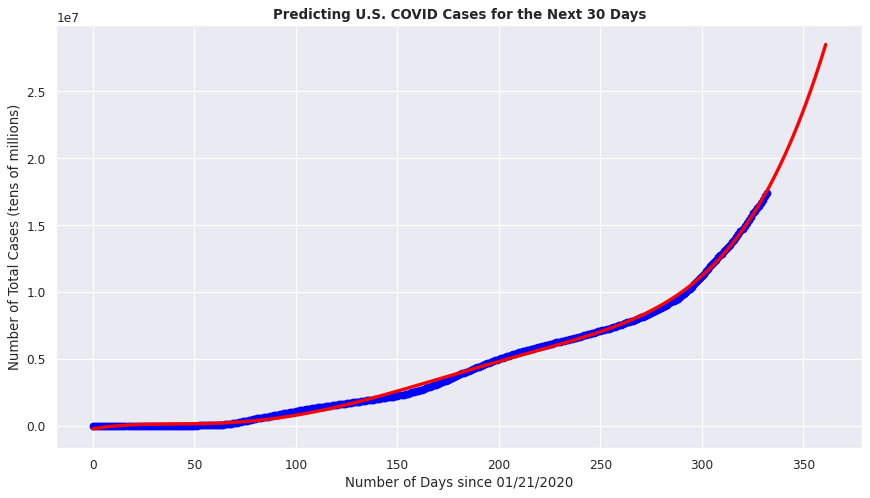

In [138]:
# Use the model to predict the total number of cases for the next 30 days

# Create 30 num_days past the last date in the dataset and run the model on the new data
X_test = list(range(0, us_covid['num_days'].max() + 30))
X_trans = np.array(X_test).reshape(len(X_test), 1)
X_trans = poly.fit_transform(X_trans)
y_pred = reg.predict(X_trans)


# Plot the model
plt.figure(num=None, figsize=(13, 7), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(us_covid['num_days'].to_numpy(), us_covid['cases'].to_numpy(),  color='blue')
plt.plot(X_test, y_pred, color='red', linewidth=3)
plt.xticks()
plt.yticks()
plt.title('Predicting U.S. COVID Cases for the Next 30 Days', fontweight='bold')
plt.xlabel('Number of Days since 01/21/2020')
plt.ylabel('Number of Total Cases (tens of millions)')
plt.show()

Using linear regression, we were able to successfully create a model that fits the data pretty well. Without using large polynomial degrees, we were able to obtain these results using a degree of 5. Considering an r^2 value of over 0.99, we can reject the null hypothesis of the relationship between the number of COVID cases in the United States and time. It is evident that there is a near exponential increase in cases as time increases. The data resembles the real world effects of the virus spreading faster when more people have it. 

One interesting thing to note here is that it took around [330 days for the United States to reach 17 million cases](https://www.thedenverchannel.com/news/national/coronavirus/us-surpasses-17-million-covid-19-cases-has-recorded-1-million-new-cases-in-less-than-a-week). Using the predictions generated by the model (as shown with the red line), it can be estimated that the United States will add an additional 10 million cases in just the next 30 days. This number assumes nothing changes about the trend of cases increases, which is likely to go down as the [vaccine begins its rollout](https://www.medscape.com/viewarticle/942774) and [states reinstate social distancing policies](https://www.wusa9.com/article/news/verify/maryland-phase-1-fact-check-baltimore-county-what-is-open-reversing-governor-larry-hogan-what-phase-is-maryland-in-today/65-9f8fbba8-a134-408a-b5b8-37e6221aff79). 

### 5.B Linear Regression for Predicting the Total Number of Deaths <a name="5.B"></a>

In [139]:
# Run SKLearn Linear Regression model on num_days to predict the total number of cases
# Gather X and y values
X = us_covid['num_days'].values.reshape(us_covid['num_days'].count(), 1)
y = us_covid['deaths'].values

# Create interaction features for num_days 
poly = PolynomialFeatures(degree=6, include_bias=False)
X_pf = poly.fit_transform(X)

# Generate the model
reg = linear_model.LinearRegression()
reg.fit(X_pf, y)

# Predict outcomes
us_covid['pred_deaths'] = reg.predict(X_pf)

# Print model info
print("The linear model is: y = " + str(reg.coef_[0]) + "*x1 + " + str(reg.coef_[1]) + "*x2 + " + \
      str(reg.coef_[2]) + "*x3 + " + str(reg.coef_[3]) + "*x4 + " + str(reg.coef_[4]) + "*x5 " + \
      str(reg.coef_[5]) + "*x6 + " + str(reg.intercept_))
print("The mean squared error is: " + str(mean_squared_error(us_covid['pred_deaths'], us_covid['deaths'])))
print("The r^2 score is: " + str(r2_score(us_covid['pred_deaths'], us_covid['deaths'])))


The linear model is: y = -1666.6467002844352*x1 + 37.69020701958393*x2 + -0.21708932447962417*x3 + 0.0005733664081098776*x4 + -7.247958918044084e-07*x5 4.4303760660113767e-10*x6 + 13236.925157451624
The mean squared error is: 35588886.67378795
The r^2 score is: 0.99583175096262


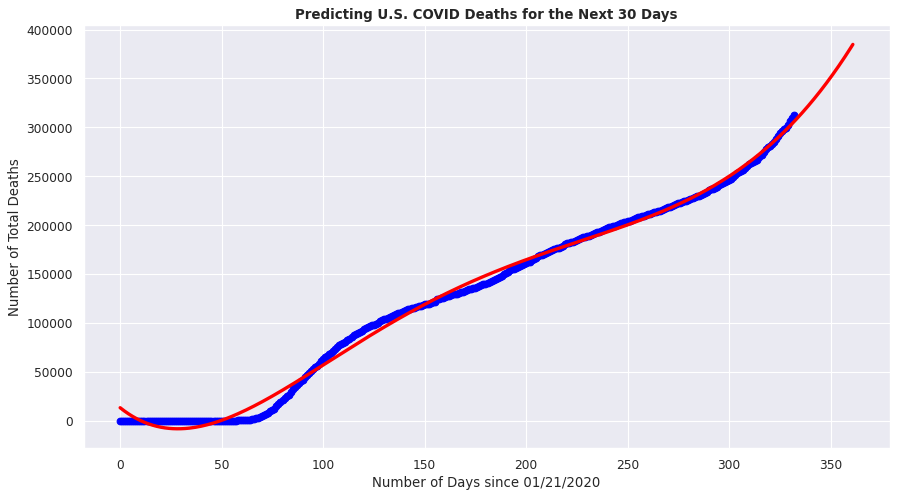

In [140]:
# Use the model to predict the total number of deaths for the next 30 days

# Create 30 num_days past the last date in the dataset and run the model on the new data
X_test = list(range(0, us_covid['num_days'].max() + 30))
X_trans = np.array(X_test).reshape(len(X_test), 1)
X_trans = poly.fit_transform(X_trans)
y_pred = reg.predict(X_trans)

# Plot the model
plt.figure(num=None, figsize=(13, 7), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(us_covid['num_days'].to_numpy(), us_covid['deaths'].to_numpy(),  color='blue')
plt.plot(X_test, y_pred, color='red', linewidth=3)
plt.xticks()
plt.yticks()
plt.title('Predicting U.S. COVID Deaths for the Next 30 Days', fontweight='bold')
plt.xlabel('Number of Days since 01/21/2020')
plt.ylabel('Number of Total Deaths')
plt.show()

For creating a model for the number of deaths, we followed the same process as we did for cases earlier. This model uses a polynoimal degree of 6 and also receives a r^2 score of over 0.99. The validation of the model allows us to reject the null hypothesis again regarding the relationship between COVID deaths and time. 

Just as with cases, the model predicts there will be a significant rise in total deaths within the next 30 days compared to the past. It took the U.S. around [330 days to reach 320,000 deaths](https://apnews.com/article/us-coronavirus-deaths-300k-361f7128ba7ae1f4168cf1622555b93f), however the model predicts it will add around another 150,000 to that number in 30 days. Despite these high predictions, it is unlikely that this will represent the true number of deaths in the future as medical advancements and new policies are implemented. 

### 5.C Classifying States' Political Outcomes with Their COVID Data Using Random Forest Classification <a name="5.C"></a>

In [141]:
# Random Forest Classifier

# Prepare the DataFrame to only consist of num_days, cases, deaths, cases_adj, deaths_adj, and winner
political_df = state_covid.copy()
political_df = political_df.drop(columns=['date', 'state', 'region', 'population', \
                                          'region_name', 'code', 'state_num'])

# Represent target variable in binary form to work with the model generator
political_df['winner_binary'] = political_df['winner'].transform(lambda x: 0 if x == 'Biden' else 1)
display(political_df.head(3))

# get features and target data from DataFrame
X = political_df.iloc[:, [0, 1, 2, 3, 4]]
y = political_df.iloc[:, 6]

scores = []
error = []

# 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True)

# for each fold (split)
for train_index, test_index in kf.split(X):

    # separate data into training and testing
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

    # run SKLearn random forest classifier using max_depth of 20 and 40 estimators
    classifier = RandomForestClassifier(n_estimators=40, max_depth=20)
    classifier.fit(X_train, y_train)
    
    # predict values using weights from classifier
    y_pred = classifier.predict(X_test)
    
    # calculate scores
    scores.append(r2_score(y_pred, y_test))
    error.append(mean_squared_error(y_pred, y_test))

# print out the average scores
print("The 10-fold cross validation score for random forest is: " + str(sum(scores) / len(scores)))
print("The 10-fold cross validation mean squared error for random forest is: " + str(sum(error) / len(error)))

cases  deaths  num_days     cases_adj  deaths_adj winner  winner_binary
0      1       0         0  1.313216e-07         0.0  Biden              0
1      1       0         1  1.313216e-07         0.0  Biden              0
2      1       0         2  1.313216e-07         0.0  Biden              0

The 10-fold cross validation score for random forest is: 0.8369276215753162
The 10-fold cross validation mean squared error for random forest is: 0.040703245388326384


Now that we know there is a trend between cases and deaths over time, we want to see if we can use those trends for each state to classify which political candidate they voted for during the 2020 Presidential Election. We originally tried using logistic regression and a decision tree classifier, however they were unable to provide a model that performed well. We then resorted to using a random forest classifier as this classifier is able to consider many decision trees at the same time.

The target features that we used were cases, deaths, cases adjusted for population, deaths adjusted for population, and the number of days since 01/21/2020 (the first date recorded in the dataset). Originally, we just used cases and deaths, however this feature-set performed well even with the random forest classifier. Since we are also using adjusted values based on population, the model is implicity considering the state's population when determining the political outcome. The target feature of the model is the political candidate represented in a binary form. In this case, Joe Biden is represented by a 0 and Donald Trump is represented by a 1.

We trained and validated the model using a [10 fold cross validation](https://machinelearningmastery.com/k-fold-cross-validation/#:~:text=Cross%2Dvalidation%20is%20a%20resampling,is%20to%20be%20split%20into.). The minimum number of estimators and lowest max depth we were able to achieve was 40 estimators and a max depth of 20. We are able to obtain an r^2 score of above 0.80, which indicates the model is mostly able to predict that state's election winner, however there are sometimes when it cannot. It is likely that using just the aforementioned features (without any feature engineering) does not provide sufficient information for the model to make very accurate predictions. If we were to make another model to classify this data, we might considering using [interaction features](https://christophm.github.io/interpretable-ml-book/interaction.html) to see if the additional information can provide better results.

## 6. Policy Insights and Conclusions <a name="6"></a>

The data does show a correlation between a greater number of COVID cases and states won by Trump in the 2020 election. The exact reason for this is unknown. It is generally believed that Trump supporters are, to put it mildly, [skeptical of the pandemic](https://www.pewresearch.org/fact-tank/2020/10/21/only-24-of-trump-supporters-view-the-coronavirus-outbreak-as-a-very-important-voting-issue/). It is also believed that these same people don’t like the idea of [being forced to wear a mask](https://today.yougov.com/topics/politics/articles-reports/2020/10/03/how-trump-and-biden-supporters-differ-face-masks). This analysis does not definitively prove either of these beliefs; it only shows a correlation between Trump supporting states and a greater number of COVID cases. Interestingly, it was found that Biden states seem to have a higher mortality rate of COVID. Why would states with less cases have more deaths? We could speculate on this, but it would take another analysis to determine the cause for this. This analysis could serve as a stepping stone for such an analysis. 

It was also interesting to see the difference in the plots of the number of cases compared to the plot of the number of deaths. It’s possible that the reason for this is that hospitals were overwhelmed with cases towards the beginning of the pandemic leading to more deaths as people couldn’t get treatment. It was also interesting to see the difference between the different regions. Specifically, the northeast was impacted the most by the pandemic. This analysis is insufficient to determine why that is, but it may be worth investigating. 

It would be interesting to do further analysis on this topic to determine specifically what factors were the most effective in curbing the spread of the pandemic. This analysis is a stepping stone for that as it showed which areas of the country had success and which did not in “[flattening the curve](https://healthblog.uofmhealth.org/wellness-prevention/flattening-curve-for-covid-19-what-does-it-mean-and-how-can-you-help)”. It is important to note some limitations of the study as well. The data used is publicly available data on case numbers and deaths since January. These numbers are estimates and may be inaccurate as well if certain states underreported case numbers or death numbers as a large Senate election was also set to take place in many states in 2020. In addition, there was speculation of [overreporting of COVID deaths](https://www.cidrap.umn.edu/news-perspective/2020/07/about-30-covid-deaths-may-not-be-classified-such) by certain hospitals, perhaps in order to increase funding. This analysis has no way of verifying the accuracy of the numbers reported, so it is worth noting that any trends seen here should be examined with some caution. That being said, the data we used overall lent itself to analysis remarkably well. 

It is our hope that this study can provide some insight, to any reading it, on the pandemic that has plagued our country for the majority of 2020. It has been a frustrating year not just because of the pandemic but also due to the difficulty in trusting most mainstream media sources that have picked a side in the politicization of the pandemic. This analysis has tried to free itself of any such bias in the hopes of contributing in an objective manner to the ongoing discussion of how to handle this unprecedented situation in the most effective way. We hope that the reader has found it insightful and can use it to make more sense of what is going on. 
